# Sklearn pipelines: missing values
> Exploring missing value imputation techniques and how to combine them in a Sklearn pipeline.

- toc: true 
- badges: true
- comments: true
- categories: [sklearn]

## Load packages and data

Instead of doing all the package imports in the beginning of the file, I'll simply load the basic packages first and then all the rest at the moment of usage.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import seaborn as sns

It's always a good idea to look at the data first

In [2]:
df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
print(df.shape)
df.dtypes

(1460, 81)


Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [4]:
df.describe().round()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.0,1460.0,1201.0,1460.0,1460.0,1460.0,1460.0,1460.0,1452.0,1460.0,...,1460.0,1460.0,1460.0,1460.0,1460.0,1460.0,1460.0,1460.0,1460.0,1460.0
mean,730.0,57.0,70.0,10517.0,6.0,6.0,1971.0,1985.0,104.0,444.0,...,94.0,47.0,22.0,3.0,15.0,3.0,43.0,6.0,2008.0,180921.0
std,422.0,42.0,24.0,9981.0,1.0,1.0,30.0,21.0,181.0,456.0,...,125.0,66.0,61.0,29.0,56.0,40.0,496.0,3.0,1.0,79443.0
min,1.0,20.0,21.0,1300.0,1.0,1.0,1872.0,1950.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2006.0,34900.0
25%,366.0,20.0,59.0,7554.0,5.0,5.0,1954.0,1967.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,129975.0
50%,730.0,50.0,69.0,9478.0,6.0,5.0,1973.0,1994.0,0.0,384.0,...,0.0,25.0,0.0,0.0,0.0,0.0,0.0,6.0,2008.0,163000.0
75%,1095.0,70.0,80.0,11602.0,7.0,6.0,2000.0,2004.0,166.0,712.0,...,168.0,68.0,0.0,0.0,0.0,0.0,0.0,8.0,2009.0,214000.0
max,1460.0,190.0,313.0,215245.0,10.0,9.0,2010.0,2010.0,1600.0,5644.0,...,857.0,547.0,552.0,508.0,480.0,738.0,15500.0,12.0,2010.0,755000.0


It's quite small dataset with 1460 rows, but has a lot of features - both numeric and categorical.  The dependent variable is `SalePrice`, which we aim to predict.  Right from the initial exploration we can notice some features with missing values, let's vizualize them next.

## Vizualize missing values

I will use a small utility plotting function, that could be reused in other projects as well.

In [5]:
def plot_missing_values(df):
    """ For each column with missing values plot proportion that is missing."""
    data = [(col, df[col].isnull().sum() / len(df)) 
            for col in df.columns if df[col].isnull().sum() > 0]
    col_names = ['column', 'percent_missing']
    missing_df = pd.DataFrame(data, columns=col_names).sort_values('percent_missing')
    pylab.rcParams['figure.figsize'] = (15, 8)
    missing_df.plot(kind='barh', x='column', y='percent_missing'); 
    plt.title('Percent of missing values in colummns');

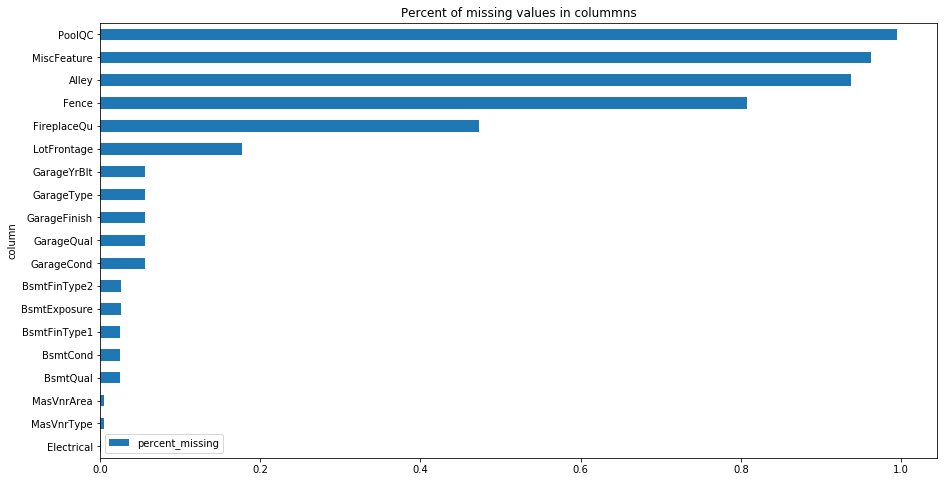

In [6]:
plot_missing_values(df)

There definitely are features with missing values in this dataset, but they vary greatly in the level of missingness - from just a few to nearly all.  
It could be that reasons for missingness are different - `PoolQC`, `GarageYrBlt`, `BsmntFinType` are probably missing because not all houses have pools, garages and basements. Whereas `LotFrontage` could be missing because of data quality.  In real life problems it is essential to figure out the reasons for missingness, but for the sake of this post let's just focus on the imputation techniques.  

There are myriad of ways how to deal with missing data, for example:  
 * Removing rows with missing values;
 * Removing features with high proportion of missing values;
 * Replacing missing values with a constant value;
 * Replacing missing values with mean/median/mode (globally or grouped/clustered);
 * Imputing missing values using models.   

In this post, I will explore the last 3 options, since the first 2 are quite trivial and, because it's a small dataset, we want to keep as much data as possible.

## Constant value imputation

As a first step, let's try to replace missing values with some constants and establish a baseline. Since we have mixed datatypes, we first need to separate into categorical and numerical columns, for this I will write a custom selector transformer that will conveniently integrate into the rest of the pipeline and allow seamless preprocessing of the test set.  

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

class ColumnSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, dtype):
        self.dtype = dtype
    
    def fit(self, X, y=None):
        """ Get either categorical or numerical columns on fit.
        Store as attribute for future reference"""
        X = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        if self.dtype == 'numerical':
            self.cols = X.select_dtypes(exclude='O').columns.tolist()
        elif self.dtype == 'categorical':
            self.cols = X.select_dtypes(include='O').columns.tolist()
        self.col_idx = [df.columns.get_loc(col) for col in self.cols]
        return self

    def transform(self, X):
        """ Subset columns of chosen data type and return np.array"""
        X = X.values if isinstance(X, pd.DataFrame) else X
        return X[:, self.col_idx]

Let's combine selector and imputer for numerical and categorical columns into single pipeline and check the results.  
For imputation I will use Sklearn's SimpleImputer. This might seem as an overkill, as it might as well be achieved using simple `.fillna()` method from pandas, however, we are going to be working with pipelines and move towards more complicated methods later, where usefulness of these transformers will shine, just trust me :)

In [8]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer

num_pipe = Pipeline([
    ('num_selector', ColumnSelector('numerical')),
    ('num_imputer', SimpleImputer(strategy='constant', fill_value=0))
])

cat_pipe = Pipeline([
    ('cat_selector', ColumnSelector('categorical')),
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='None'))
])

preproc = FeatureUnion([
    ('num_pipe', num_pipe),
    ('cat_pipe', cat_pipe)
])

Let's check if the output has any missing values.

In [9]:
def check_missing(X):
    print('Number of missing values after imputation: {}'.
          format(pd.DataFrame(X).isnull().sum().sum()))

In [10]:
imputed_res = preproc.fit_transform(df)
check_missing(imputed_res)

Number of missing values after imputation: 0


As expected, no missing values after imputation.  
Inspect plots for a chosen categorical and numeric variable with missing values to get a better intuition on what was done here.

In [11]:
def get_df_from_pipeline_res(pipeline_res, pipeline):
    """ Get pandas dataframe from the results of fitted pipeline"""
    num_cols = pipeline.get_params()['num_pipe']['num_selector'].cols
    cat_cols = pipeline.get_params()['cat_pipe']['cat_selector'].cols
    return pd.DataFrame(pipeline_res, columns=num_cols + cat_cols)

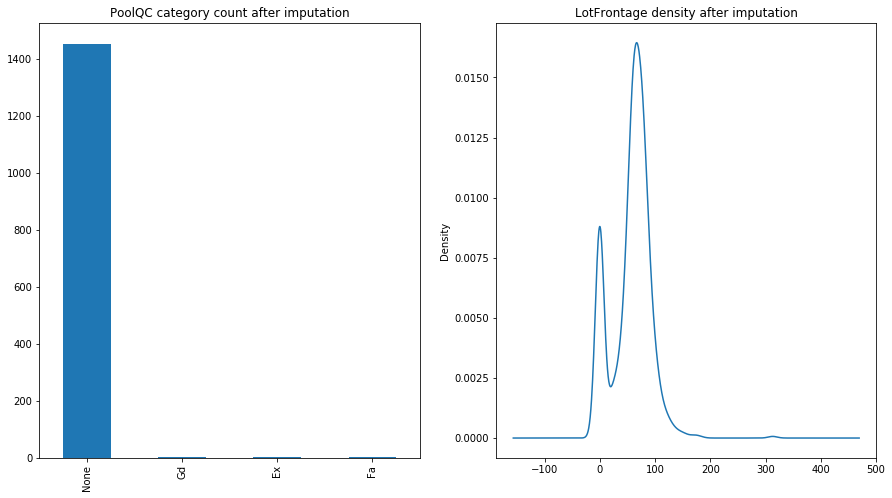

In [12]:
_ = get_df_from_pipeline_res(imputed_res, preproc)
f, ax = plt.subplots(1, 2)
ax = ax.flatten()
_.PoolQC.value_counts().plot(kind='bar', ax=ax[0]);
ax[0].title.set_text('PoolQC category count after imputation');
_.LotFrontage.plot(kind='kde', ax=ax[1]);
ax[1].title.set_text('LotFrontage density after imputation');

As expected, SimpleImputer did it's job and added 'None' category to categorical variables and 0 value for numeric missing values.

## Establish baseline result

As always in machine learning, it's best to make minimum required number of assumptions and test, if decisions actually improve the predictions.  Similarly in this case, because using constant imputation is the simplest approach, let's get the model score, consider it a benchmark and then try out more sophisticated techniques to improve upon it.  

For this I will use default RandomForestRegressor with 100 trees. First separate X and y.

In [13]:
y = df.SalePrice
X = df.drop('SalePrice', axis=1)

Since the model expects all the features to be numerical, we need to deal with the categorical columns, let's add OneHotEncoder to the pipeline.

In [14]:
from sklearn.preprocessing import OneHotEncoder

preproc.get_params()['cat_pipe'].steps.append([
    'ohe', OneHotEncoder(sparse=False, handle_unknown='ignore')
])

Set an instance of simple Random Forest model.

In [15]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42,
                              oob_score=True, n_jobs=-1)

Set up the pipeline combining preporcessing and modelling steps.

In [16]:
estimator = Pipeline([
    ('preproc', preproc),
    ('model', model)
])

Create RMSLE scorer as target for optimization.

In [17]:
from sklearn.metrics import make_scorer, mean_squared_log_error

def rmsle(y, y_pred):
    return -np.sqrt(mean_squared_log_error(y, y_pred))

scoring = make_scorer(rmsle, greater_is_better=False)

Set up grid with 5-fold cross-validation.

In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = {}
grid = GridSearchCV(estimator, param_grid, scoring=scoring, n_jobs=-1, cv=5)
grid.fit(X, y);

Get the benchmark result for RMSE and it's standard deviation from cross validation results.

In [19]:
benchmark = grid.cv_results_['mean_test_score'], grid.cv_results_['std_test_score']
benchmark

(array([0.14783474]), array([0.00659506]))

Our baseline model has a cross-validated RMSLE around .15, which for totally plain vanilla model is fairly ok.  
Let's see if we can beat this just by adding more sophisticated missing value imputation techniques.

## Median / Most frequent replacement

Next, let's try `median` and `most_frequent` imputation strategies. It means that the imputer will consider each feature separately and estimate median for numerical columns and most frequent value for categorical columns. It should be stressed that both must be estimated on **the training set**, otherwise it will cause data leakage and poor generalization. Luckily, pipelines ensure this, even when performing cross validation.  

Also be sure to include the indicator for missing values, as it adds some information for the algorithm in cases, where the chosen imputation strategy was not entirely appropriate. For example, `PoolQC` has the most frequent value `Gd`, which will replaces NA values with strategy set to `most_frequent`, but that is obviously wrong, as most houses don't have a pool! Hence having an indicator partially offsets this introduced noise.

In [20]:
estimator.get_params()

{'memory': None, 'steps': [('preproc', FeatureUnion(n_jobs=None,
                transformer_list=[('num_pipe',
                                   Pipeline(memory=None,
                                            steps=[('num_selector',
                                                    ColumnSelector(dtype='numerical')),
                                                   ('num_imputer',
                                                    SimpleImputer(add_indicator=False,
                                                                  copy=True,
                                                                  fill_value=0,
                                                                  missing_values=nan,
                                                                  strategy='constant',
                                                                  verbose=0))],
                                            verbose=False)),
                                  ('cat_pipe',
   

In [21]:
grid.param_grid =  param_grid = {
    'preproc__num_pipe__num_imputer__strategy': ['median'],
    'preproc__num_pipe__num_imputer__add_indicator': [True],
    'preproc__cat_pipe__cat_imputer__strategy': ['most_frequent'],
    'preproc__cat_pipe__cat_imputer__add_indicator': [True],
}
grid.fit(X, y)
grid.cv_results_['mean_test_score'], grid.cv_results_['std_test_score']

(array([0.14654323]), array([0.00808575]))

Score improved very marginally. In real life scenarios we would like to inspect further, for which features `most_frequent` and `median` imputation is more appropriate than just simply setting to `None` and zero.  
Let's illustrate this for two variables already discussed before to get a better feel for what's happening under the hood.

In [22]:
# Prepare data for plotting, checking same 2 variables as before
tmp_preproc = dict(dict(grid.best_estimator_.get_params()['steps'])['preproc'].transformer_list)
lot_frontage_imputed = tmp_preproc['num_pipe']['num_imputer'].fit_transform(X[['LotFrontage']])[:, 0]
pool_qc_imputed = tmp_preproc['cat_pipe']['cat_imputer'].fit_transform(X[['PoolQC']])[:, 0]

res = np.vstack((lot_frontage_imputed, X['LotFrontage'].fillna(0), pool_qc_imputed, X['PoolQC'].fillna('None'))).T
cols = ['lot_frontage_imputed', 'lot_frontage_zero_fill', 'pool_qc_imputed', 'pool_qc_const_fill']
_ = pd.DataFrame(res, columns=cols)
_.head()

,lot_frontage_imputed,lot_frontage_zero_fill,pool_qc_imputed,pool_qc_const_fill
0,65,65,Gd,None
1,80,80,Gd,None
2,68,68,Gd,None
3,60,60,Gd,None
4,84,84,Gd,None


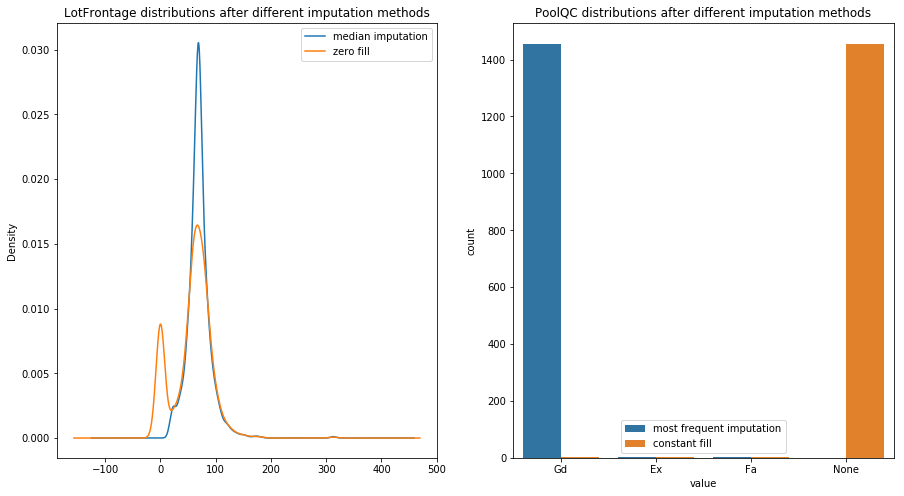

In [23]:
# Plot distributions for both variables after both methods
fig, ax = plt.subplots(1, 2)
ax = ax.flatten()

_.lot_frontage_imputed.plot(kind='kde', ax=ax[0])
_.lot_frontage_zero_fill.plot(kind='kde', ax=ax[0])
ax[0].legend(labels=['median imputation','zero fill'])
ax[0].set_title('LotFrontage distributions after different imputation methods')

ax[1] = sns.countplot(data=pd.melt(_[['pool_qc_imputed', 'pool_qc_const_fill']]), x='value', hue='variable')
ax[1].legend(labels=['most frequent imputation','constant fill'])
ax[1].set_title('PoolQC distributions after different imputation methods');

If LotFrontage is truly missing and each house has it, then median imputation looks much better than zero fill.  
However, for PoolQC most frequent is not a valid method as it fills with `Gd` quality as default, in cases where actually there's no pool, as argued above.

## Iterative imputation of numerical features

Next we're going to use IterativeImputer, which is still in Sklearn's experimental stage: https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html  
It's using iterative multivariate regression to impute missing values.  

We'll built a custom transfomer that performs the whole imputation process in the following sequence:
* Create mask for values to be iteratively imputed (in cases where > 50% values are missing, use constant fill).
* Replace all missing values with constants (`None` for categoricals and zeroes for numericals).
* Apply ordinal encoder to numericalize categorical values, store encoded values.
* Use previously created mask to fill back `NaN` values before iterative imputation.
* Apply iterative imputer using `KNeighborsRegressor` as estimator.
* Convert back from imputed numerical values to categorical values, by inverting fitted ordinal encoder.

Phew! This sounds quite complicated, let's see if it improves the result.

In [24]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OrdinalEncoder

class CustomImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self, n_neighbors=5, weights='uniform', algorithm='ball_tree'):
        self.n_neighbors=n_neighbors
        self.weights=weights
        self.algorithm=algorithm
    
    def fit(self, X, y=None):
        self.get_column_metadata(X)
        return self
    
    def get_column_metadata(self, X):
        """ Fit column selector, get names and indices for categorical and numerical columns."""
        self.cat_cols = ColumnSelector('categorical').fit(X).cols
        self.num_cols = ColumnSelector('numerical').fit(X).cols
    
    def transform(self, X):
        """ Takes in X dataframe of unprocessed features and returns
        dataframe without missing values, either imputed using MICE
        method or constant imputation, depending on proportion of missing values
        in a column."""
        X = X.copy()
        impute_mask = self.get_impute_mask(X)
        X_no_nan = self.replace_nan_const(X)
        X_cat_numericalized = self.apply_ordinal_encoder(X_no_nan[self.cat_cols])
        X_numericalized = np.hstack((X_cat_numericalized, X_no_nan[self.num_cols]))
        X_fill_back_nan = self.fill_back_nan(X_numericalized, impute_mask)
        X_imputed = self.apply_imputer(X_fill_back_nan)
        return pd.DataFrame(self.invert_cat_encoder(X_imputed),
                            columns=self.cat_cols + self.num_cols)
    
    def get_impute_mask(self, X):
        """ Get boolean mask marking value locations that need to be iteratively imputed.
        Only impute those columns, where proportion of missing values is <50%.
        Otherwise leave constant imputation."""
        cols_most_values_missing = [col for col in X.columns
                                    if X[col].isnull().sum() / X.shape[0] > .5]
        impute_mask = X.isnull()
        impute_mask[cols_most_values_missing] = False
        return impute_mask    

    def replace_nan_const(self, X):
        """ Use fitted ColumnSelector to get categorical and numerical column names.
        Fill missing values with 'None' and zero constants accordingly."""
        X[self.cat_cols] = X[self.cat_cols].fillna('None')
        X[self.num_cols] = X[self.num_cols].fillna(0)
        return X
    
    def apply_ordinal_encoder(self, X_no_nan_cat):
        """ Apply OrdinalEncoder to categorical columns,
        to get integer values for all categories, including missing.
        Make encoder available on class scope, for inversion later."""
        self.ordinal_encoder = OrdinalEncoder()
        X_cat_inverted = self.ordinal_encoder.fit_transform(X_no_nan_cat)
        return X_cat_inverted
    
    def fill_back_nan(self, X_numericalized, impute_mask):
        """ Replace back constant values with nan's, according to imputation mask."""
        X_numericalized[impute_mask] = np.nan
        return X_numericalized
    
    def apply_imputer(self, X_fill_back_nan):
        """ Use IterativeImputer to predict missing values."""
        imputer = IterativeImputer(estimator=KNeighborsRegressor(n_neighbors=self.n_neighbors, 
                                                                 weights=self.weights, 
                                                                 algorithm=self.algorithm),
                                   random_state=42)
        return imputer.fit_transform(X_fill_back_nan)
    
    def invert_cat_encoder(self, X_imputed):
        """ Invert ordinal encoder to get back categorical values"""
        X_cats = X_imputed[:, :len(self.cat_cols)].round()
        X_cat_inverted = self.ordinal_encoder.inverse_transform(X_cats)
        X_numerics = X_imputed[:, len(self.cat_cols):]
        return np.hstack((X_cat_inverted, X_numerics))

Create custom One-Hot-Encoder for categorical features, that uses categorical column names from already fitted `CustomImputer`.

In [25]:
from sklearn.compose import ColumnTransformer

class CustomEncoder(BaseEstimator, TransformerMixin):
        
    def fit(self, X, y=None):
        ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
        ohe.fit(X)
        cat_cols = imputer['imputer'].cat_cols
        self.ct = ColumnTransformer([('ohe', ohe, cat_cols)], remainder='passthrough')
        self.ct.fit(X)
        return self
    
    def transform(self, X):
        return self.ct.transform(X)

Create pipeline that applies `CustomImputer` and `CustomEncoder` in separate steps.

In [26]:
imputer = Pipeline([
    ('imputer', CustomImputer())
])

preproc = Pipeline([
    ('imputer', imputer),
    ('encoder', CustomEncoder())
])

Check the outpout of new preprocessor.

In [27]:
preproc_res = preproc.fit_transform(X)
print(preproc_res.shape, check_missing(preproc_res))
pd.DataFrame(preproc_res).head()

Number of missing values after imputation: 0
(1460, 304) None


,0,1,2,3,4,5,6,7,8,9,...,294,295,296,297,298,299,300,301,302,303
0,0,0,0,1,0,0,1,0,1,0,...,548,0,61,0,0,0,0,0,2,2008
1,0,0,0,1,0,0,1,0,1,0,...,460,298,0,0,0,0,0,0,5,2007
2,0,0,0,1,0,0,1,0,1,0,...,608,0,42,0,0,0,0,0,9,2008
3,0,0,0,1,0,0,1,0,1,0,...,642,0,35,272,0,0,0,0,2,2006
4,0,0,0,1,0,0,1,0,1,0,...,836,192,84,0,0,0,0,0,12,2008


In [28]:
estimator = Pipeline([
    ('preproc', preproc),
    ('model', model)
])

grid.estimator =  estimator

In [29]:
grid.param_grid = {
    'preproc__imputer__imputer__n_neighbors': [3, 5, 10, 15, 20],
    'preproc__imputer__imputer__weights': ['uniform', 'distance']
}

In [30]:
grid.fit(X, y)
grid.cv_results_['mean_test_score'], grid.cv_results_['std_test_score']

/opt/conda/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/opt/conda/lib/python3.6/site-packages/sklearn/impute/_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


(array([0.15051219, 0.15047996, 0.1494927 , 0.14943995, 0.150222  ,
        0.14972539, 0.14900967, 0.14833345, 0.14951359, 0.14907698]),
 array([0.00803959, 0.00797067, 0.00813004, 0.0083092 , 0.008971  ,
        0.00871621, 0.00871822, 0.00898254, 0.0074017 , 0.00782198]))

In [31]:
grid.best_estimator_

Pipeline(memory=None,
         steps=[('preproc',
                 Pipeline(memory=None,
                          steps=[('imputer',
                                  Pipeline(memory=None,
                                           steps=[('imputer',
                                                   CustomImputer(algorithm='ball_tree',
                                                                 n_neighbors=3,
                                                                 weights='uniform'))],
                                           verbose=False)),
                                 ('encoder', CustomEncoder())],
                          verbose=False)),
                ('model',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                          

Results didn't improve, because in this problem most of the variables have missing values not at random, but rather missing values having actual meaning, so doing iterative imputation only adds noise.  

Anyway, it was a fun exercise to play around with the concept and hopefully it could be reused with other datasets in the future.  
Of course, there are other variations, tuning and estimators to play around with, but this should at least give inspiration to get started :)  

Suggestions and comments are appreciated!